# Data loading and preprocessing

In [ ]:
import os, json
import numpy as np
import cv2
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from skimage.io import imread
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd

In [ ]:
!wget nipg1.inf.elte.hu:8765/MOSI.zip

--2022-01-28 11:06:01--  http://nipg1.inf.elte.hu:8765/MOSI.zip
Resolving nipg1.inf.elte.hu (nipg1.inf.elte.hu)... 157.181.160.161
Connecting to nipg1.inf.elte.hu (nipg1.inf.elte.hu)|157.181.160.161|:8765... connected.
HTTP request sent, awaiting response... 200 OK
Length: 513767740 (490M) [application/zip]
Saving to: ‘MOSI.zip’

MOSI.zip            100%[===================>] 489.97M  3.36MB/s    in 85s     

2022-01-28 11:07:26 (5.79 MB/s) - ‘MOSI.zip’ saved [513767740/513767740]



In [45]:
!unzip -o MOSI.zip

Archive:  MOSI.zip
  inflating: MOSI/labels.csv         
  inflating: MOSI/videos/_dI--eQ6qVU_1.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_10.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_11.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_12.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_13.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_14.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_15.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_16.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_17.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_18.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_19.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_2.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_20.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_21.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_22.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_23.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_24.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_25.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_26.mp4  
  inflating: MOSI/videos/_dI--eQ6qVU_27.mp4  
  inflating: MOSI/videos/

In [46]:
!ls MOSI

labels.csv  videos


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('MOSI/videos/cXypl4FnoZo_27.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
mp4 = open('MOSI/videos/c5xsKMxpXnc_11.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
!mkdir -p cXypl4FnoZo_27
!ffmpeg -i MOSI/videos/cXypl4FnoZo_27.mp4 -vf fps=30 cXypl4FnoZo_27/frame%03d.jpg

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
!ls cXypl4FnoZo_27 | wc -l

94


In [ ]:
frame_paths = sorted(os.listdir('cXypl4FnoZo_27/'))
frames = []
for frame_path in frame_paths:
   frame = cv2.cvtColor(cv2.imread(f'cXypl4FnoZo_27/{frame_path}'), cv2.COLOR_BGR2RGB)
   frames.append(frame)
frames = np.stack(frames)
print(frames.shape)

(94, 360, 640, 3)


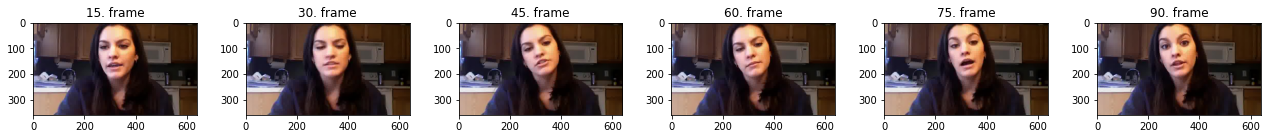

In [ ]:
fig = plt.figure(figsize=(22, 8))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
indices = list(range(0, frames.shape[0], int(frames.shape[0]/6)))
for plot_ind in range(1,7):
    plt.subplot(1, 6, plot_ind)
    plt.title(f'{indices[plot_ind]}. frame')
    plt.imshow(frames[indices[plot_ind]])

In [ ]:
video = cv2.VideoCapture('MOSI/videos/c5xsKMxpXnc_11.mp4');
fps = video.get(cv2.CAP_PROP_FPS)
ret, frame = video.read()
print('read:', bool(ret), 'fps:', fps, 'frame shape:', frame.shape)
frames = []
while ret:
   frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
   ret, frame = video.read()
frames = np.stack(frames)
print(frames.shape)

read: True fps: 30.0 frame shape: (720, 1280, 3)
(91, 720, 1280, 3)


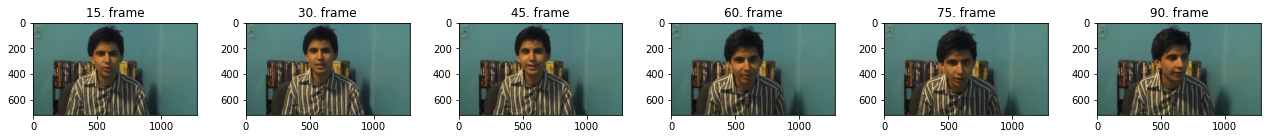

In [ ]:
fig = plt.figure(figsize=(22, 8))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
indices = list(range(0, frames.shape[0], int(frames.shape[0]/6)))
for plot_ind in range(1,7):
    plt.subplot(1, 6, plot_ind)
    plt.title(f'{indices[plot_ind]}. frame')
    plt.imshow(frames[indices[plot_ind]])

In [ ]:
signal, sr = librosa.load('MOSI/videos/cXypl4FnoZo_27.mp4', sr=16000)

In [ ]:
print('shape:', signal.shape, 'sr:', sr, 'duration:', signal.shape[0]/sr, 'sec')

shape: (49784,) sr: 16000 duration: 3.1115 sec


In [ ]:
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)

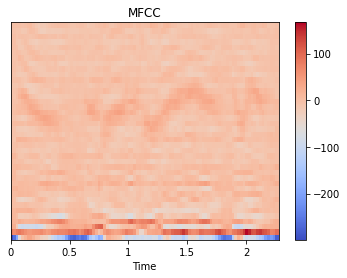

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
_ = ax.set(title='MFCC')

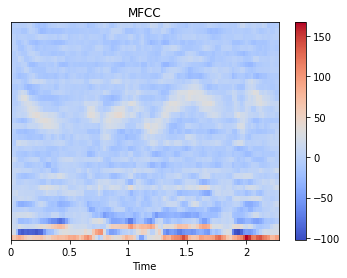

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs[1:], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
_ = ax.set(title='MFCC')

In [ ]:
melspec = librosa.feature.melspectrogram(y=signal, sr=16000, n_mels=128, fmax=8000)
melspec_db = librosa.power_to_db(melspec, ref=np.max)

In [ ]:
print('shape:', melspec_db.shape, 'min value:', melspec_db.min(), 'max value:', melspec_db.max())

shape: (128, 98) min value: -80.0 max value: 0.0


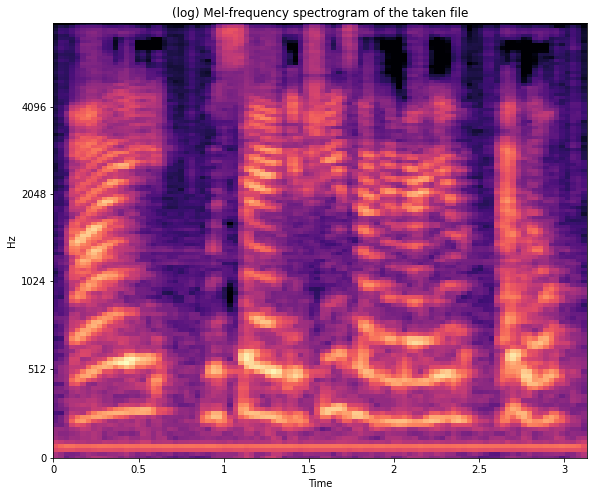

In [ ]:
fig = plt.figure(figsize=(22, 8))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
plt.subplot(1, 2, 1)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
_ = plt.title('(log) Mel-frequency spectrogram of the taken file')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


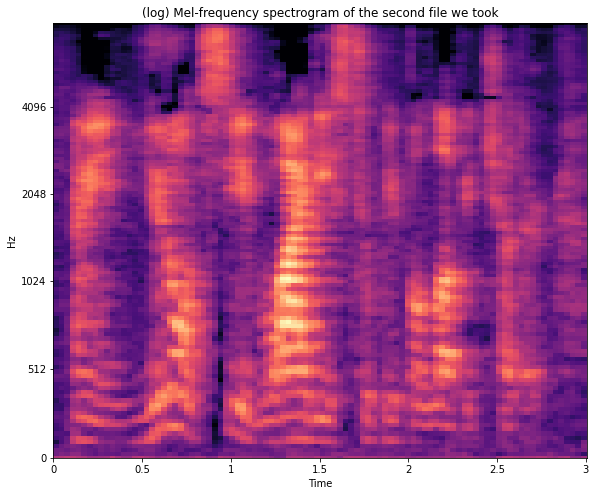

In [ ]:
signal, sr = librosa.load('MOSI/videos/c5xsKMxpXnc_11.mp4', sr=16000)
melspec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, fmax=8000)
melspec_db = librosa.power_to_db(melspec, ref=np.max)
fig = plt.figure(figsize=(22, 8))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
plt.subplot(1, 2, 1)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
_ = plt.title('(log) Mel-frequency spectrogram of the second file we took')

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/TadasBaltrusaitis/OpenFace.git'
project_name = splitext(basename(git_repo_url))[0]
# clone openface
!git clone -q --depth 1 $git_repo_url

# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
!tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# Get newest GCC
!sudo apt-get update
!sudo apt-get install build-essential 
!sudo apt-get install g++-8

# install python dependencies
!pip install -q youtube-dl

# Finally, actually install OpenFace
!cd OpenFace && bash ./download_models.sh && sudo bash ./install.sh

Streaming output truncated to the last 5000 lines.
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_mask_operations/mat_mask_operations.cpp  
   creating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_operations/
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_operations/mat_operations.cpp  
   creating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_the_basic_image_container/
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_the_basic_image_container/mat_the_basic_image_container.cpp  
   creating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/AKAZE_match.cpp  
   creating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/AKAZE_tracking/
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/AKAZE_tracking/planar_tracking.cpp  
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/AKAZE_tracking/stats.h  
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/featu

In [ ]:
!./OpenFace/build/bin/FeatureExtraction -f MOSI/videos/cXypl4FnoZo_27.mp4 -out_dir processed
!ffmpeg -y -loglevel info -i processed/cXypl4FnoZo_27.avi output.mp4

Could not find the HAAR face detector location
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenFace/build/bin/mode

VISUAL OUTPUT

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('MOSI/videos/cXypl4FnoZo_27.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
!pip install opensmile
import opensmile

In [ ]:
!ffmpeg -i MOSI/videos/cXypl4FnoZo_27.mp4 audio.wav

In [ ]:
smile = opensmile.Smile(
    feature_set = opensmile.FeatureSet.ComParE_2016,
    feature_level = opensmile.FeatureLevel.LowLevelDescriptors,
)
y = smile.process_file('audio.wav')
print('ComParE_2016 llds shape:', y.shape)

In [ ]:
smile = opensmile.Smile(
    feature_set = opensmile.FeatureSet.ComParE_2016,
    feature_level = opensmile.FeatureLevel.Functionals,
)
y = smile.process_file('audio.wav')
print('ComParE_2016 functionals shape:', y.shape)

In [ ]:
smile = opensmile.Smile(
    feature_set = opensmile.FeatureSet.eGeMAPSv02,
    feature_level = opensmile.FeatureLevel.LowLevelDescriptors,
)
y = smile.process_file('audio.wav')
print('eGeMAPSv02 llds shape:', y.shape)

eGeMAPSv02 llds shape: (307, 25)


In [ ]:
smile = opensmile.Smile(
    feature_set = opensmile.FeatureSet.eGeMAPSv02,
    feature_level = opensmile.FeatureLevel.Functionals,
)
y = smile.process_file('audio.wav')
print('eGeMAPSv02 functionals shape:', y.shape)

eGeMAPSv02 functionals shape: (1, 88)


In [ ]:
VIDEO_DIR = 'MOSI/videos'
LABEL_PATH = 'MOSI/labels.csv'

In [ ]:
labels = pd.read_csv(LABEL_PATH)
labels['Sentiment_Binary'] = (labels['Sentiment'] == 'positive').astype(int)
labels = labels.drop(['Start', 'End', 'Sentiment'], axis=1)
labels.head()

,Filename,Score,Type,Sentiment_Binary
0,03bSnISJMiM_1,2.40,train,1
1,03bSnISJMiM_2,-0.80,train,0
2,03bSnISJMiM_3,-1.00,train,0
3,03bSnISJMiM_4,-1.75,train,0
4,03bSnISJMiM_5,0.00,train,1


In [ ]:
train_labels = labels[labels['Type'] == 'train']
print('Number of labels in train:', len(train_labels))
train_labels.head()

Number of labels in train: 1284


,Filename,Score,Type,Sentiment_Binary
0,03bSnISJMiM_1,2.40,train,1
1,03bSnISJMiM_2,-0.80,train,0
2,03bSnISJMiM_3,-1.00,train,0
3,03bSnISJMiM_4,-1.75,train,0
4,03bSnISJMiM_5,0.00,train,1


In [ ]:
valid_labels = labels[labels['Type'] == 'valid']
print('Number of labels in valid:', len(valid_labels))
valid_labels.head()

Number of labels in valid: 229


,Filename,Score,Type,Sentiment_Binary
1284,WKA5OygbEKI_1,1.8,valid,1
1285,WKA5OygbEKI_2,2.2,valid,1
1286,WKA5OygbEKI_3,1.2,valid,1
1287,WKA5OygbEKI_4,1.8,valid,1
1288,WKA5OygbEKI_5,0.6,valid,1


In [ ]:
test_labels = labels[labels['Type'] == 'test']
print('Number of labels in test:', len(test_labels))
test_labels.head()

Number of labels in test: 686


,Filename,Score,Type,Sentiment_Binary
1513,c7UH_rxdZv4_1,-2.8,test,0
1514,c7UH_rxdZv4_2,-2.6,test,0
1515,c7UH_rxdZv4_3,-0.8,test,0
1516,c7UH_rxdZv4_4,1.6,test,1
1517,c7UH_rxdZv4_5,-2.2,test,0


In [ ]:
video_list = [os.path.join(VIDEO_DIR, name) for name in os.listdir(VIDEO_DIR)]
print('[All] Number of videos:', len(video_list))
print('[All] Examples:', video_list[:3])

[All] Number of videos: 2199
[All] Examples: ['MOSI/videos/dq3Nf_lMPnE_14.mp4', 'MOSI/videos/bvLlb-M3UXU_24.mp4', 'MOSI/videos/2WGyTLYerpo_58.mp4']


In [ ]:
from pathlib import Path

In [ ]:
train_video_list = sorted([name for name in video_list if Path(name).stem in set(train_labels['Filename'])])
print('[Train] Number of videos:', len(train_video_list))
print('[Train] Examples:', train_video_list[:3])

[Train] Number of videos: 1284
[Train] Examples: ['MOSI/videos/03bSnISJMiM_1.mp4', 'MOSI/videos/03bSnISJMiM_10.mp4', 'MOSI/videos/03bSnISJMiM_11.mp4']


In [ ]:
valid_video_list = sorted([name for name in video_list if Path(name).stem in set(valid_labels['Filename'])])
print('[Valid] Number of videos:', len(valid_video_list))
print('[Valid] Examples:', valid_video_list[:3])

In [ ]:
test_video_list = sorted([name for name in video_list if Path(name).stem in set(test_labels['Filename'])])
print('[Test] Number of videos:', len(test_video_list))
print('[Test] Examples:', test_video_list[:3])

[Test] Number of videos: 686
[Test] Examples: ['MOSI/videos/c7UH_rxdZv4_1.mp4', 'MOSI/videos/c7UH_rxdZv4_10.mp4', 'MOSI/videos/c7UH_rxdZv4_11.mp4']
[Test] Number of videos: 686
[Test] Examples: ['MOSI/videos/c7UH_rxdZv4_1.mp4', 'MOSI/videos/c7UH_rxdZv4_10.mp4', 'MOSI/videos/c7UH_rxdZv4_11.mp4']


In [ ]:
class MosiDataset(torch.utils.data.Dataset):
   def __init__(self, labels: pd.DataFrame, path: str):
      self.labels = labels
      self.path = Path(path)
    
   def __len__(self):
      return len(self.labels)
  
   def __getitem__(self, index):
      # determine sample
      sample = self.labels.iloc[index]
      id = str(sample['Filename'])

      # get input data
      X = np.array( f'{id}.mp4') # now, it is the video path for debugging purposes
      # X = np.load(str(self.path / f'{id}.npy')) # you can load precomputed opensmile/openface features
      # X = [
      #   np.load(str(self.path_features1 / f'{id}.npy')),
      #   np.load(str(self.path_features2 / f'{id}.npy'))
      # ] # you can load multiple input modalities

      # get target label
      #y = float(sample['Score']) # for regression
      y = float(sample['Sentiment_Binary']) # for classification
      return X, y

In [ ]:
train_set = MosiDataset(train_labels, VIDEO_DIR)
print('Len:', len(train_set))

for i, (X, y) in enumerate(train_set):
   print(f'{i}. sample')
   print(f'X: {X}')
   print(f'y: {y}')
   print('='*40)

Streaming output truncated to the last 5000 lines.
34. sample
X: 0h-zjBukYpk_22.mp4
y: 1.0
35. sample
X: 0h-zjBukYpk_23.mp4
y: 1.0
36. sample
X: 0h-zjBukYpk_24.mp4
y: 1.0
37. sample
X: 0h-zjBukYpk_25.mp4
y: 1.0
38. sample
X: 1DmNV9C1hbY_1.mp4
y: 0.0
39. sample
X: 1DmNV9C1hbY_2.mp4
y: 1.0
40. sample
X: 1DmNV9C1hbY_3.mp4
y: 1.0
41. sample
X: 1DmNV9C1hbY_4.mp4
y: 1.0
42. sample
X: 1DmNV9C1hbY_5.mp4
y: 0.0
43. sample
X: 1DmNV9C1hbY_6.mp4
y: 0.0
44. sample
X: 1DmNV9C1hbY_7.mp4
y: 0.0
45. sample
X: 1DmNV9C1hbY_8.mp4
y: 0.0
46. sample
X: 1DmNV9C1hbY_9.mp4
y: 1.0
47. sample
X: 1DmNV9C1hbY_10.mp4
y: 1.0
48. sample
X: 1DmNV9C1hbY_11.mp4
y: 0.0
49. sample
X: 1DmNV9C1hbY_12.mp4
y: 1.0
50. sample
X: 1DmNV9C1hbY_13.mp4
y: 0.0
51. sample
X: 1DmNV9C1hbY_14.mp4
y: 0.0
52. sample
X: 1iG0909rllw_1.mp4
y: 0.0
53. sample
X: 1iG0909rllw_2.mp4
y: 0.0
54. sample
X: 1iG0909rllw_3.mp4
y: 1.0
55. sample
X: 1iG0909rllw_4.mp4
y: 0.0
56. sample
X: 1iG0909rllw_5.mp4
y: 1.0
57. sample
X: 1iG0909rllw_6.mp4
y: 1.0
58. 

In [ ]:
test_set = MosiDataset(test_labels, VIDEO_DIR)
print('Len:', len(test_set))

for i, (X, y) in enumerate(test_set):
   print(f'{i}. sample')
   print(f'X: {X}')
   print(f'y: {y}')
   print('='*40)

Len: 686
0. sample
X: c7UH_rxdZv4_1.mp4
y: 0.0
1. sample
X: c7UH_rxdZv4_2.mp4
y: 0.0
2. sample
X: c7UH_rxdZv4_3.mp4
y: 0.0
3. sample
X: c7UH_rxdZv4_4.mp4
y: 1.0
4. sample
X: c7UH_rxdZv4_5.mp4
y: 0.0
5. sample
X: c7UH_rxdZv4_6.mp4
y: 0.0
6. sample
X: c7UH_rxdZv4_7.mp4
y: 0.0
7. sample
X: c7UH_rxdZv4_8.mp4
y: 0.0
8. sample
X: c7UH_rxdZv4_9.mp4
y: 0.0
9. sample
X: c7UH_rxdZv4_10.mp4
y: 1.0
10. sample
X: c7UH_rxdZv4_11.mp4
y: 1.0
11. sample
X: c7UH_rxdZv4_12.mp4
y: 0.0
12. sample
X: c7UH_rxdZv4_13.mp4
y: 0.0
13. sample
X: c7UH_rxdZv4_14.mp4
y: 1.0
14. sample
X: c7UH_rxdZv4_15.mp4
y: 0.0
15. sample
X: c7UH_rxdZv4_16.mp4
y: 0.0
16. sample
X: c7UH_rxdZv4_17.mp4
y: 0.0
17. sample
X: c7UH_rxdZv4_18.mp4
y: 0.0
18. sample
X: c7UH_rxdZv4_19.mp4
y: 0.0
19. sample
X: c7UH_rxdZv4_20.mp4
y: 0.0
20. sample
X: c7UH_rxdZv4_21.mp4
y: 0.0
21. sample
X: c7UH_rxdZv4_22.mp4
y: 0.0
22. sample
X: c7UH_rxdZv4_23.mp4
y: 0.0
23. sample
X: c7UH_rxdZv4_24.mp4
y: 0.0
24. sample
X: c7UH_rxdZv4_25.mp4
y: 1.0
25. sample

In [ ]:
valid_set = MosiDataset(valid_labels, VIDEO_DIR)
print('Len:', len(valid_set))

for i, (X, y) in enumerate(valid_set):
   print(f'{i}. sample')
   print(f'X: {X}')
   print(f'y: {y}')
   print('='*40)

Len: 229
0. sample
X: WKA5OygbEKI_1.mp4
y: 1.0
1. sample
X: WKA5OygbEKI_2.mp4
y: 1.0
2. sample
X: WKA5OygbEKI_3.mp4
y: 1.0
3. sample
X: WKA5OygbEKI_4.mp4
y: 1.0
4. sample
X: WKA5OygbEKI_5.mp4
y: 1.0
5. sample
X: WKA5OygbEKI_6.mp4
y: 0.0
6. sample
X: WKA5OygbEKI_7.mp4
y: 1.0
7. sample
X: WKA5OygbEKI_8.mp4
y: 1.0
8. sample
X: WKA5OygbEKI_9.mp4
y: 1.0
9. sample
X: WKA5OygbEKI_10.mp4
y: 0.0
10. sample
X: WKA5OygbEKI_11.mp4
y: 0.0
11. sample
X: WKA5OygbEKI_12.mp4
y: 1.0
12. sample
X: WKA5OygbEKI_13.mp4
y: 1.0
13. sample
X: WKA5OygbEKI_14.mp4
y: 1.0
14. sample
X: WKA5OygbEKI_15.mp4
y: 1.0
15. sample
X: WKA5OygbEKI_16.mp4
y: 1.0
16. sample
X: WKA5OygbEKI_17.mp4
y: 1.0
17. sample
X: WKA5OygbEKI_18.mp4
y: 1.0
18. sample
X: WKA5OygbEKI_19.mp4
y: 0.0
19. sample
X: WKA5OygbEKI_20.mp4
y: 1.0
20. sample
X: WKA5OygbEKI_21.mp4
y: 1.0
21. sample
X: WKA5OygbEKI_22.mp4
y: 1.0
22. sample
X: X3j2zQgwYgE_1.mp4
y: 1.0
23. sample
X: X3j2zQgwYgE_2.mp4
y: 0.0
24. sample
X: X3j2zQgwYgE_3.mp4
y: 0.0
25. sample
X:

In [ ]:
!./OpenFace/build/bin/FeatureExtraction -f MOSI/videos/cXypl4FnoZo_27.mp4 -out_dir processed
!ffmpeg -y -loglevel info -i processed/cXypl4FnoZo_27.avi output.mp4

Could not find the HAAR face detector location
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenFace/build/bin/mode

In [ ]:
import pandas as pd
df = pd.read_csv('processed/cXypl4FnoZo_27.csv')
df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,...,p_29,p_30,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000,0.98,1,-0.069795,0.343072,-0.936713,-0.317907,0.328324,-0.889460,-0.209,0.352,278.3,279.8,284.5,289.4,291.8,290.6,285.6,280.6,271.9,274.9,279.2,284.5,289.9,293.9,296.9,293.9,289.4,284.4,279.6,275.3,283.1,285.3,287.3,288.0,287.0,284.8,282.8,...,-0.114,0.275,0.020,0.043,0.204,0.0,0.0,1.10,0.00,0.0,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2.66,1.14,0.32,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,2,0,0.033,0.98,1,-0.064096,0.343521,-0.936955,-0.323795,0.327884,-0.887496,-0.209,0.353,278.1,279.7,284.3,289.3,291.7,290.5,285.5,280.6,271.7,274.7,278.9,284.2,289.5,293.6,296.7,293.8,289.2,284.2,279.4,275.1,283.0,285.2,287.2,287.9,286.8,284.7,282.6,...,-0.182,0.315,0.016,0.052,0.207,0.0,0.0,1.16,0.00,0.0,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2.64,1.23,0.30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,3,0,0.067,0.98,1,-0.064801,0.342430,-0.937306,-0.320789,0.328855,-0.888228,-0.208,0.352,278.1,279.7,284.3,289.2,291.7,290.5,285.5,280.5,271.8,274.7,278.8,284.1,289.5,293.6,296.8,293.7,289.2,284.1,279.4,275.1,283.0,285.2,287.2,287.9,286.8,284.6,282.6,...,-0.184,0.312,0.012,0.055,0.208,0.0,0.0,1.16,0.00,0.0,0.64,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2.63,1.32,0.49,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,4,0,0.100,0.98,1,-0.002688,0.326528,-0.945184,-0.328948,0.374269,-0.867016,-0.181,0.369,277.8,279.8,285.0,290.4,292.7,291.1,285.5,280.2,272.0,274.7,278.5,283.5,289.1,293.9,297.6,293.8,288.6,283.1,278.5,274.7,283.2,285.6,287.9,288.9,287.8,285.4,283.0,...,-0.198,0.208,0.112,-0.037,-0.143,0.0,0.0,1.10,0.02,0.0,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,2.55,1.39,0.66,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,5,0,0.133,0.98,1,-0.063215,0.315803,-0.946717,-0.337786,0.348025,-0.874516,-0.217,0.350,275.9,277.6,282.3,287.3,289.6,288.4,283.2,278.2,270.4,272.9,276.6,281.6,287.1,291.7,295.3,291.6,286.6,281.4,276.9,273.1,281.1,283.2,285.2,285.9,284.9,282.8,280.8,...,-0.200,0.171,-0.077,-0.033,0.050,0.0,0.0,1.01,0.02,0.0,0.52,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,2.50,1.45,0.83,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [ ]:
for i, (X, y) in enumerate(train_set):
  print(f'{i}. sample')
  !./OpenFace/build/bin/FeatureExtraction -f {X} -out_dir processed/train
  !ffmpeg -y -loglevel info -i {X} processed/train/output{i}.mp4
  !ffmpeg -i {X} audio{i}.wav
  print('='*40)

0. sample
Could not find the HAAR face detector location
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenFace/buil

In [ ]:
for i, (X, y) in enumerate(test_set):
  print(f'{i}. sample')
  !./OpenFace/build/bin/FeatureExtraction -f {X} -out_dir processed/test
  !ffmpeg -y -loglevel info -i {X} processed/test/output{i}.mp4
  !ffmpeg -i {X}.mp4 audio{i}.wav
  print('='*40)

0. sample
Could not find the HAAR face detector location
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenFace/buil

In [ ]:
for i, (X, y) in enumerate(valid_set):
  print(f'{i}. sample')
  !./OpenFace/build/bin/FeatureExtraction -f {X} -out_dir processed/valid
  !ffmpeg -y -loglevel info -i {X} processed/valid/output{i}.mp4
  !ffmpeg -i {X} audio{i}.wav
  print('='*40)
  if i == 2: break

0. sample
Could not find the HAAR face detector location
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenFace/buil

In [ ]:
import sys, os, os.path
from scipy.io import wavfile
import pandas as pd

input_filename = input("Input file number:")
if input_filename[-3:] != 'wav':
    print('WARNING!! Input File format should be *.wav')
    sys.exit()

samrate, data = wavfile.read(str('./wavfile/' + input_filename))
print('Load is Done! \n')

wavData = pd.DataFrame(data)

if len(wavData.columns) == 2:
    print('Stereo .wav file\n')
    wavData.columns = ['R', 'L']
    stereo_R = pd.DataFrame(wavData['R'])
    stereo_L = pd.DataFrame(wavData['L'])
    print('Saving...\n')
    stereo_R.to_csv(str(input_filename[:-4] + "_Output_stereo_R.csv"), mode='w')
    stereo_L.to_csv(str(input_filename[:-4] + "_Output_stereo_L.csv"), mode='w')
    # wavData.to_csv("Output_stereo_RL.csv", mode='w')
    print('Save is done ' + str(input_filename[:-4]) + '_Output_stereo_R.csv , '
                          + str(input_filename[:-4]) + '_Output_stereo_L.csv')

elif len(wavData.columns) == 1:
    print('Mono .wav file\n')
    wavData.columns = ['M']

    wavData.to_csv(str(input_filename[:-4] + "_Output_mono.csv"), mode='w')

    print('Save is done ' + str(input_filename[:-4]) + '_Output_mono.csv')

else:
    print('Multi channel .wav file\n')
    print('number of channel : ' + len(wavData.columns) + '\n')
    wavData.to_csv(str(input_filename[:-4] + "Output_multi_channel.csv"), mode='w')

    print('Save is done ' + str(input_filename[:-4]) + 'Output_multi_channel.csv')